In [1]:
import numpy as np
import pandas as pd
from numpy import pi
import qiskit
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import plot_state_city, plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info.random.utils import random_state
import random
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [2]:
# imports IBMQ backends
from qiskit.providers.ibmq import IBMQ
ibmq_provider = IBMQ.load_account()        # credentials stored on disk
simulator = ibmq_provider.get_backend('ibmq_qasm_simulator')
device = ibmq_provider.get_backend('ibmq_burlington')

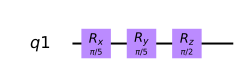

In [3]:
R=[]
n=3
qreg = QuantumRegister(n)
for i in range(3):
    R.append(random.randint(1,10))
qreg_exp = QuantumRegister(1)
qc_expected = QuantumCircuit(qreg_exp)
qc_expected.rx(pi/10*R[0],0)
qc_expected.ry(pi/10*R[1],0)
qc_expected.rz(pi/10*R[2],0)
#qc_expected.x(0)
qc_expected.draw(output='mpl')


The expected state is: [0.90953518+0.j         0.32312398+0.26141279j]


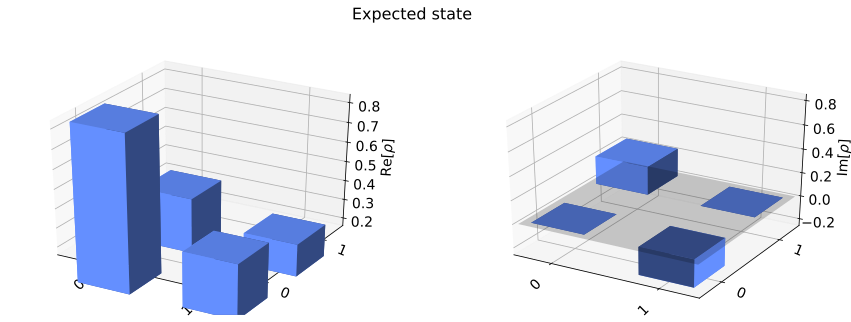

In [4]:
job = qiskit.execute(qc_expected, Aer.get_backend('statevector_simulator'))
psi_expected = job.result().get_statevector(qc_expected)
print('The expected state is:', psi_expected)
plot_state_city(psi_expected, title='Expected state')

[0.90953518+0.j         0.32312398+0.26141279j]


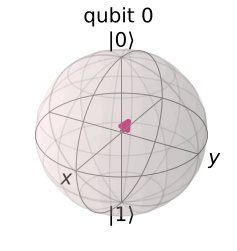

In [5]:
simulatorvec = Aer.get_backend('statevector_simulator')
result = execute(qc_expected, backend = simulatorvec).result()
statevector = result.get_statevector()
print(statevector)
%matplotlib inline
plot_bloch_multivector(statevector)

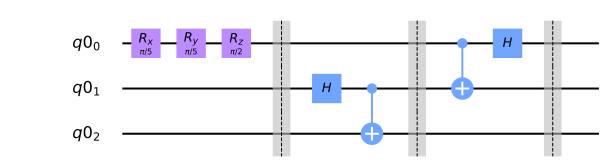

In [6]:
qc1 = QuantumCircuit(qreg)
qc1.rx(pi/10*R[0],0)
qc1.ry(pi/10*R[1],0)
qc1.rz(pi/10*R[2],0)
#qc1.x(0)
qc1.barrier()
qc1.h(1)
qc1.cx(1,2)
qc1.barrier()
qc1.cx(0,1)
qc1.h(0)
qc1.barrier()
qc1.draw(output='mpl')

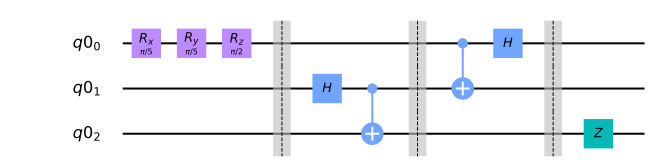

In [7]:
qc2 = QuantumCircuit(qreg)
qc3 = QuantumCircuit(qreg)
qc4 = QuantumCircuit(qreg)
qcs = [qc1, qc2, qc3, qc4]
for qc in range(3):
    q2 = QuantumCircuit(qreg)
    if qc == 0 or qc == 2:
        q2.z(2)
    if qc == 1 or qc == 2:
        q2.x(2)
    qcs[qc+1]= qcs[0] +q2
qcs[1].draw(output='mpl')

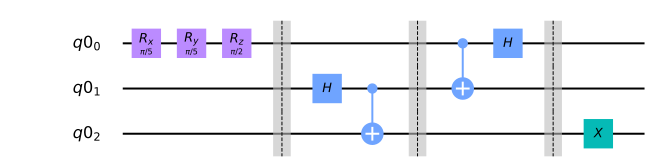

In [8]:
qcs[2].draw(output='mpl')

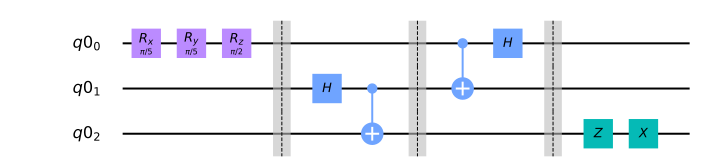

In [9]:
qcs[3].draw(output='mpl')

In [10]:
backends = [simulator, device]
bits = [ '010', '101', '000', '001', '100', '011', '111', '110']
paulis = [('Z','Z','X'),('Z','Z','Y'),('Z','Z','Z')]

for be in backends:
    state = {'X': {'0': 0, '1': 0}, 'Y': {'0': 0, '1': 0}, 'Z': {'0': 0, '1': 0}}
    for qc in qcs:
        qst_circuit = state_tomography_circuits(qc,qreg)
        job = qiskit.execute(qst_circuit, be, shots=1000)
        print('Done job.')
        if be == device:
            job_monitor(job)
        tom = StateTomographyFitter(job.result(), qst_circuit)
        if qc == qc1:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0

            state.update({'X': {'0': state['X']['0']+tom.data[('Z','Z','X')]['000'],
                                '1': state['X']['1']+tom.data[('Z','Z','X')]['100']}})
            state.update({'Y': {'0': state['Y']['0']+tom.data[('Z','Z','Y')]['000'],
                                '1': state['Y']['1']+tom.data[('Z','Z','Y')]['100']}})
            state.update({'Z': {'0': state['Z']['0']+tom.data[('Z','Z','Z')]['000'],
                                '1': state['Z']['1']+tom.data[('Z','Z','Z')]['100']}})
            print(state)
        if qc == qcs[1]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0

            state.update({'X': {'0': state['X']['0']+tom.data[('Z','Z','X')]['001'],
                                '1': state['X']['1']+tom.data[('Z','Z','X')]['101']}})
            state.update({'Y': {'0': state['Y']['0']+tom.data[('Z','Z','Y')]['001'],
                                '1': state['Y']['1']+tom.data[('Z','Z','Y')]['101']}})
            state.update({'Z': {'0': state['Z']['0']+tom.data[('Z','Z','Z')]['001'],
                                '1': state['Z']['1']+tom.data[('Z','Z','Z')]['101']}})
            print(state)

        if qc == qcs[2]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0

            state.update({'X': {'0': state['X']['0']+tom.data[('Z','Z','X')]['010'],
                                '1': state['X']['1']+tom.data[('Z','Z','X')]['110']}})
            state.update({'Y': {'0': state['Y']['0']+tom.data[('Z','Z','Y')]['010'],
                                '1': state['Y']['1']+tom.data[('Z','Z','Y')]['110']}})
            state.update({'Z': {'0': state['Z']['0']+tom.data[('Z','Z','Z')]['010'],
                                '1': state['Z']['1']+tom.data[('Z','Z','Z')]['110']}})
            print(state)
            
        if qc == qcs[3]:
            for pauli in paulis:
                for bit in bits:
                    if bit not in tom.data[pauli]:
                        tom.data[pauli][bit]=0

            state.update({'X': {'0': state['X']['0']+tom.data[('Z','Z','X')]['011'],
                                '1': state['X']['1']+tom.data[('Z','Z','X')]['111']}})
            state.update({'Y': {'0': state['Y']['0']+tom.data[('Z','Z','Y')]['011'],
                                '1': state['Y']['1']+tom.data[('Z','Z','Y')]['111']}})
            state.update({'Z': {'0': state['Z']['0']+tom.data[('Z','Z','Z')]['011'],
                                '1': state['Z']['1']+tom.data[('Z','Z','Z')]['111']}})
    if be == simulator:
        state_sim = state
        print('The full state for simulator is', state)
    if be == device:
        state_dev = state
        print('The full state for device is', state)

Done job.
{'X': {'0': 191, '1': 58}, 'Y': {'0': 175, '1': 68}, 'Z': {'0': 190, '1': 37}}
Done job.
{'X': {'0': 385, '1': 104}, 'Y': {'0': 370, '1': 136}, 'Z': {'0': 382, '1': 87}}
Done job.
{'X': {'0': 581, '1': 152}, 'Y': {'0': 553, '1': 200}, 'Z': {'0': 588, '1': 130}}
Done job.
The full state for simulator is {'X': {'0': 758, '1': 209}, 'Y': {'0': 743, '1': 256}, 'Z': {'0': 792, '1': 182}}
Done job.
Job Status: job has successfully run
{'X': {'0': 203, '1': 78}, 'Y': {'0': 227, '1': 58}, 'Z': {'0': 241, '1': 68}}
Done job.
Job Status: job has successfully run
{'X': {'0': 390, '1': 203}, 'Y': {'0': 370, '1': 212}, 'Z': {'0': 447, '1': 126}}
Done job.
Job Status: job has successfully run
{'X': {'0': 510, '1': 238}, 'Y': {'0': 496, '1': 280}, 'Z': {'0': 601, '1': 184}}
Done job.
Job Status: job has successfully run
The full state for device is {'X': {'0': 665, '1': 307}, 'Y': {'0': 626, '1': 363}, 'Z': {'0': 738, '1': 249}}


In [11]:
# fidelity processing for sim and dev

Iden = np.matrix('1,0;0,1')
XPaul = np.matrix('0,1;1,0')
YPaul = np.matrix('0,0-1j;0+1j,0')
ZPaul = np.matrix('1,0;0,-1')

# simulator Bloch vector
rx_sim = (state_sim['X']['0']*1 + state_sim['X']['1']*(-1)) / (state_sim['X']['0'] + state_sim['X']['1'])
ry_sim = (state_sim['Y']['0']*1 + state_sim['Y']['1']*(-1)) / (state_sim['Y']['0'] + state_sim['Y']['1'])
rz_sim = (state_sim['Z']['0']*1 + state_sim['Z']['1']*(-1)) / (state_sim['Z']['0'] + state_sim['Z']['1'])
rho_sim = (1/2)*(Iden+rx_sim*XPaul+ry_sim*YPaul+rz_sim*ZPaul)

# device Bloch vector
rx_dev = (state_dev['X']['0']*1 + state_dev['X']['1']*(-1)) / (state_dev['X']['0'] + state_dev['X']['1'])
ry_dev = (state_dev['Y']['0']*1 + state_dev['Y']['1']*(-1)) / (state_dev['Y']['0'] + state_dev['Y']['1'])
rz_dev = (state_dev['Z']['0']*1 + state_dev['Z']['1']*(-1)) / (state_dev['Z']['0'] + state_dev['Z']['1'])
rho_dev = (1/2)*(Iden+rx_dev*XPaul+ry_dev*YPaul+rz_dev*ZPaul)

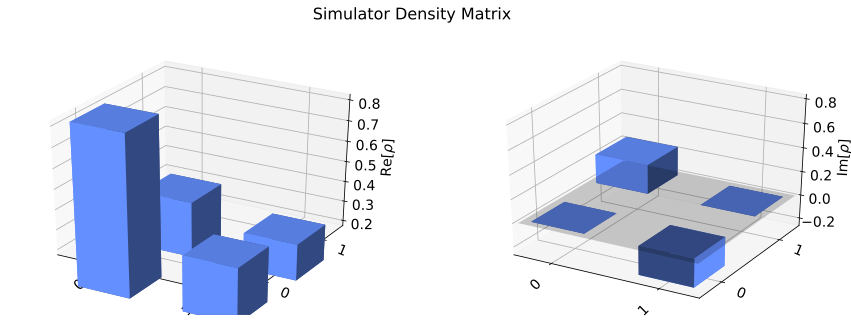

In [12]:
# these plots look a little funny for secret_h at least
plot_state_city(rho_sim, title='Simulator Density Matrix')

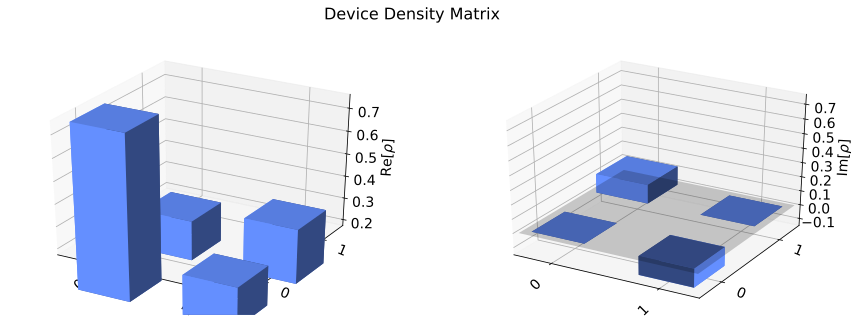

In [13]:
plot_state_city(rho_dev, title='Device Density Matrix')

In [14]:
Sim_Fidelity = state_fidelity(psi_expected, rho_sim, validate=False)
Dev_Fidelity = state_fidelity(psi_expected, rho_dev, validate=False)
print('Simulator Fidelity:', Sim_Fidelity)
print('Device Fidelity:', Dev_Fidelity)

Simulator Fidelity: 0.9877141383585364
Device Fidelity: 0.8336069552023938


In [15]:
# checking validity of the density matrices, little problem with the simulator one...
rho_dev = DensityMatrix(rho_dev)
rho_sim = DensityMatrix(rho_sim)

In [16]:
print('Is the simulator density matrix valid?', rho_sim.is_valid())
print('Is the device density matrix valid?', rho_dev.is_valid())

Is the simulator density matrix valid? True
Is the device density matrix valid? True


In [17]:
import qiskit.tools.jupyter
%qiskit_version_table